### Change to your own path

In [104]:
import sys
import os
script_path = os.path.abspath('')
module_path = script_path[:script_path.rfind('src')]+ 'src' + '/'
asset_path = script_path[:script_path.rfind('src')]+ 'asset' + '/'
sys.path.append(module_path)
from utils.Helper_functions import *
from utils.huffman import HuffmanCoding
from compression.loadData import LoadData
from scipy import signal, fftpack
from scipy import ndimage, misc, interpolate
from struct import *
import matplotlib.pyplot as plt
import numpy as np

In [18]:
loadData = LoadData()
loadData.loadVideoPixelData(asset_path + 'milkyway.png')
data_stack = loadData.image_stack
print(data_stack.shape)

(18, 165, 245, 3)


In [15]:
a = np.ones([2,3,4,5,3])
rgb2ycrcbMat = np.array([[0.2990, 0.58700, 0.11400], [-0.16874, -0.33126, 0.50000], [0.50000, -0.41869, -0.0813]])
rgb2ycrcbMat
np.multiple(a, rgb2ycrcbMat, )

array([[ 0.299  ,  0.587  ,  0.114  ],
       [-0.16874, -0.33126,  0.5    ],
       [ 0.5    , -0.41869, -0.0813 ]])

In [105]:
class JPEG:
    def __init__(self):
        self.Ql = np.array([[16,11,10,16,24,40,51,61],
                       [12,12,14,19,26,58,60,55],
                       [14,13,16,24,40,57,69,56],
                       [14,17,22,29,51,87,80,62],
                       [18,22,37,56,68,109,103,77],
                       [24,35,55,64,81,104,113,92],
                       [49,64,78,87,103,121,120,101],
                       [72,92,95,98,112,100,103,99]])
        self.Qc = np.array([[17,18,24,47,99,99,99,99],
                       [18,21,26,66,99,99,99,99],
                       [24,26,56,99,99,99,99,99],
                       [47,66,99,99,99,99,99,99],
                       [99,99,99,99,99,99,99,99],
                       [99,99,99,99,99,99,99,99],
                       [99,99,99,99,99,99,99,99],
                       [99,99,99,99,99,99,99,99]])

    def JPEG_com(self, npArray, params = {'Q':50}):
        ori_f = npArray.shape[0]
        ori_h= npArray.shape[1]
        ori_w = npArray.shape[2]
        ori_c = npArray.shape[3]

    #     crBlock = params['baseline'] # 2 by default
        Q = params['Q']
        chBlock = 2
        blockSize = 8

        for i in range(ori_frames):
            # process frame by frame
            # color decimate
            ycbcr = rgb2ycbcr(npArray[i])
            pad_w = np.ceil(ori_w/blockSize) * blockSize
            pad_h = np.ceil(ori_h/blockSize) * blockSize
            pad_ycbcr = np.pad(ycbcr, ((0, pad_h-ori_h), (0, pad_h-ori_h), (0, 0)), 'constant', constant_values = (0,0))

            Cr = pad_ycbcr[:,:,2]
            deci_Cr = Cr[0:pad_h:chBlock, 0:pad_w:chBlock].repeat(2, axis = 0).repeat(2, axis = 1)
            pad_ycbcr[:,:,2] = deci_Cr

            Cb = pad_ycbcr[:,:,1]
            deci_Cb = Cr[0:pad_h:chBlock, 0:pad_w:chBlock].repeat(2, axis = 0).repeat(2, axis = 1)
            pad_ycbcr[:,:,1] = deci_Cb

            pad_y = pad_ycbcr[:, :, 0]
            pad_cb = pad_ycbcr[:, :, 1]
            pad_cr = pad_ycbcr[:, :, 2]

            # 2d DCT
            dct_y,dct_cb,dct_cr = DCT2d(pad_ycbcr, pad_w, pad_h, blockSize)

            # quantization
            q_y, q_cb,q_cr=quantization(dct_y, dct_cb, dct_cr, Q)

            # huffman coding
    #         data = huffman_coding(q_y, q_cb, q_cr)
    #         info?

        return info, data

    def JPEG_decom(self, data, info):
        pass
    
    
    
    
    ############## compression functions ################
    def rgb2ycbcr(self, im):
        xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
        ycbcr = im.dot(xform.T)
        ycbcr[:,:,[1,2]] += 128
        return ycbcr

    def DCT2d(self, pad_ycbcr, pad_w, pad_h, blockSize):
        pad_y = pad_ycbcr[:, :, 0]
        pad_cb = pad_ycbcr[:, :, 1]
        pad_cr = pad_ycbcr[:, :, 2]

        blockNo = pad_w/blockSize * pad_h/blockSize

        ystack = reshape(pad_y, (blockSize, blockSize, blockNo))
        cbstack=reshape(pad_cb, (blockSize, blockSize, blockNo))
        crstack=reshape(pad_cr, (blockSize, blockSize, blockNo))

        dct_y = np.empty(shape = pad_y.shape)
        dct_cb = np.empty(shape = pad_y.shape)
        dct_cr = np.empty(shape = pad_y.shape)

        for i in range(blockNo):
            dct_y = dct(dct(ystack[i].T).T)

        for i in range(blockNo):
            dct_cb = dct(dct(cbstack[i].T).T)

        for i in range(blockNo):
            dct_cr = dct(dct(crstack[i].T).T)

        return np.reshape(dct_y, (pad_h, pad_w)), np.reshape(dct_cb, (pad_h, pad_w)), np.reshape(dct_cr, (pad_h, pad_w))

    def quantization(self, dct_y, dct_cb, dct_cr, Q):
        alph = lambda x:50/x if x<=50 else 2-x/50
        q_y = np.around(np.multiply(dct_y, 1./(self.Ql*alph(Q))), decimals = 0)
        q_cb = np.around(np.multiply(dct_cb, 1./(self.Qc*alph(Q))), decimals = 0)
        q_cr = np.around(np.multiply(dct_cr, 1./(self.Qc*alph(Q))), decimals = 0)

        return q_y, q_cb,q_cr



#     not now, not now
#     def huffman_coding(nparry):
#         huff = HuffmanCoding()
#         huff.compress(nparray)
    
    
    
    
    ##############decompression functions###############
    
    

In [103]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return ycbcr

def DCT2d(pad_ycbcr, pad_w, pad_h, blockSize):
    pad_y = pad_ycbcr[:, :, 0]
    pad_cb = pad_ycbcr[:, :, 1]
    pad_cr = pad_ycbcr[:, :, 2]
    
    blockNo = pad_w/blockSize * pad_h/blockSize

    ystack = reshape(pad_y, (blockSize, blockSize, blockNo))
    cbstack=reshape(pad_cb, (blockSize, blockSize, blockNo))
    crstack=reshape(pad_cr, (blockSize, blockSize, blockNo))
    
    dct_y = np.empty(shape = pad_y.shape)
    dct_cb = np.empty(shape = pad_y.shape)
    dct_cr = np.empty(shape = pad_y.shape)

    for i in range(blockNo):
        dct_y = dct(dct(ystack[i].T).T)
    
    for i in range(blockNo):
        dct_cb = dct(dct(cbstack[i].T).T)
        
    for i in range(blockNo):
        dct_cr = dct(dct(crstack[i].T).T)
        
    return np.reshape(dct_y, (pad_h, pad_w)), np.reshape(dct_cb, (pad_h, pad_w)), np.reshape(dct_cr, (pad_h, pad_w))

def quantization(dct_y, dct_cb, dct_cr, Q):
    Ql = np.array([[16,11,10,16,24,40,51,61],
                   [12,12,14,19,26,58,60,55],
                   [14,13,16,24,40,57,69,56],
                   [14,17,22,29,51,87,80,62],
                   [18,22,37,56,68,109,103,77],
                   [24,35,55,64,81,104,113,92],
                   [49,64,78,87,103,121,120,101],
                   [72,92,95,98,112,100,103,99]])
    Qc = np.array([[17,18,24,47,99,99,99,99],
                   [18,21,26,66,99,99,99,99],
                   [24,26,56,99,99,99,99,99],
                   [47,66,99,99,99,99,99,99],
                   [99,99,99,99,99,99,99,99],
                   [99,99,99,99,99,99,99,99],
                   [99,99,99,99,99,99,99,99],
                   [99,99,99,99,99,99,99,99]])
    
    alph = lambda x:50/x if x<=50 else 2-x/50
    
    q_y = np.around(np.multiply(dct_y, 1./(Ql*alph(Q))), decimals = 0)
    q_cb = np.around(np.multiply(dct_cb, 1./(Qc*alph(Q))), decimals = 0)
    q_cr = np.around(np.multiply(dct_cr, 1./(Qc*alph(Q))), decimals = 0)
                      
    return q_y, q_cb,q_cr
    
    

# not now, not now
# def huffman_coding(nparry):
#     huff = HuffmanCoding()
#     huff.compress(nparray)
    

In [102]:
# def DCT2d(channel):
#     """
#     2d nparray
#     """
#     M = channel.shape[1] # width, x
#     N = channel.shape[0] # height, y
    
#     C_m = np.array([1/pow(2, 0.5)] + [1 for i in range(0, M-1)])
#     C_n = np.array([1/pow(2, 0.5)] + [1 for i in range(0, N-1)])

#     F = np.empty([M, N])
#     for x in range(M):
#         for y in range(N):
#             F[x,y] = channel[x, y]*cos((2*x + 1)*x)
            
#     F[x,y] = 2/pow(M*N, 0.5)*C_m[x]*C_n[y]*

    
# def DCT1d(channel):
    

In [101]:
from PIL import Image
im = Image.open(asset_path +"/milkyway/frame_01.tiff")
b = np.array(im)
a = np.empty([2,2])
a[0, 0] = 1
a.shape
c = np.empty(shape = a.shape)
a[0,0] =2
c[0,0] = 3
a
c
1<=2
np.around([0.57, 1.64], decimals = 0)
a = np.array([[1,2],[3,4]])
for number in a:
    print(number)

[1 2]
[3 4]


(165, 245, 3)
(170, 250)
(170, 250)
[[95.     95.     70.5203 ...  0.      0.      0.    ]
 [95.     95.     70.5203 ...  0.      0.      0.    ]
 [96.0325 96.0325 95.5    ...  0.      0.      0.    ]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]


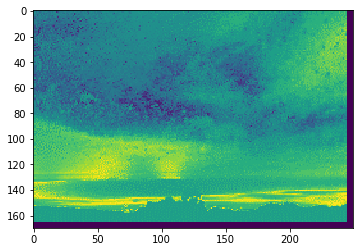

In [60]:
u = rgb2ycbcr(data_stack[0])
print(u.shape)
plt.imshow(u[:,:,2])
# print(u)
u_p = np.pad(u, ((0, 5), (0, 5),(0,0)), 'constant', constant_values = (0,0))
plt.imshow(u_p[:,:,2])
print(u_p[:,:,2].shape)
Cr = u_p[:,:,2]
deci_Cr = Cr[0:170:2, 0:250:2]
Cr_mean = deci_Cr.repeat(2, axis = 0).repeat(2, axis = 1)
u_p[:,:,2] = Cr_mean
print(Cr_mean.shape)
print(u_p[:,:,2])



In [40]:
np.ceil(20/8) * 8

24.0